<a href="https://colab.research.google.com/github/vedith1999/enhancing-sales-forecast-accuracy-salesforce-crm-ml/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             classification_report, roc_curve, precision_recall_curve)
from sklearn.calibration import calibration_curve

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Sales Dataset.xlsx to Sales Dataset.xlsx


In [ ]:
df = pd.read_excel("Sales Dataset.xlsx")
df.columns = [c.replace("\n"," ").strip() for c in df.columns]

In [ ]:
df = df.dropna(subset=["Opportunity Status","Opportunity Size (USD)"]).copy()
df["is_won"] = (df["Opportunity Status"].str.strip().str.lower()=="won").astype(int)
df["actual_revenue"] = np.where(df["is_won"]==1, df["Opportunity Size (USD)"], 0.0)

In [ ]:
use_cols = [
    "Technology Primary","B2B Sales Medium","Client Revenue Sizing",
    "Client Employee Sizing","Business from Client Last Year","Compete Intel",
    "Sales Velocity","Sales Stage Iterations","Opportunity Size (USD)"
]
data = df[use_cols + ["is_won"]].dropna().copy()

X = data.drop(columns=["is_won"])
y = data["is_won"]

X_num = X.select_dtypes(include=[np.number]).columns.tolist()
X_cat = X.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), X_cat),
    ("num", "passthrough", X_num)
])

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

pipe = Pipeline([("prep", preprocess), ("rf", rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)


In [ ]:
roc_auc = roc_auc_score(y_test, proba)
pr_auc  = average_precision_score(y_test, proba)
rep     = classification_report(y_test, pred, digits=3)
print(f"ROC-AUC: {roc_auc:.3f}\nPR-AUC: {pr_auc:.3f}\n")
print(rep)

ROC-AUC: 0.844
PR-AUC: 0.645

              precision    recall  f1-score   support

           0      0.875     0.933     0.903     10815
           1      0.675     0.510     0.581      2939

    accuracy                          0.843     13754
   macro avg      0.775     0.722     0.742     13754
weighted avg      0.832     0.843     0.834     13754



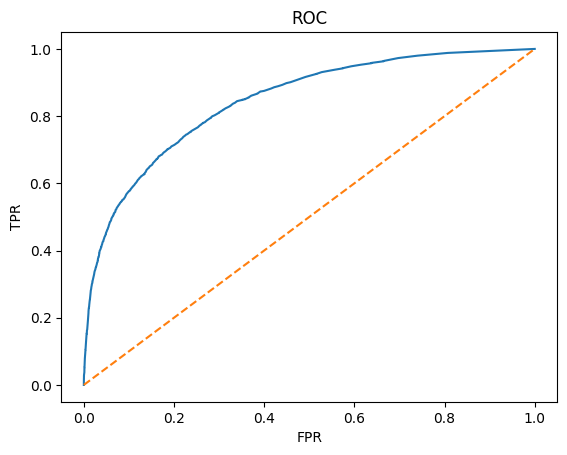

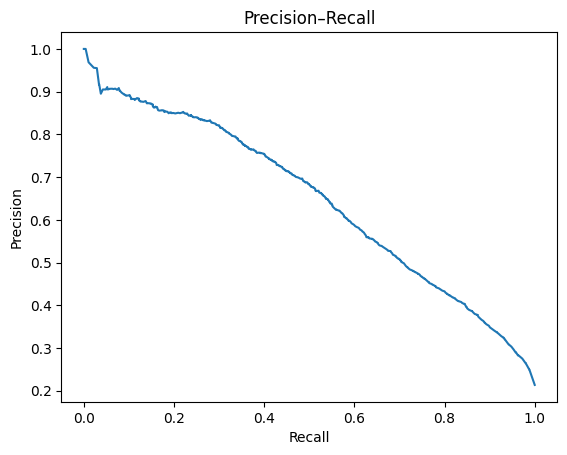

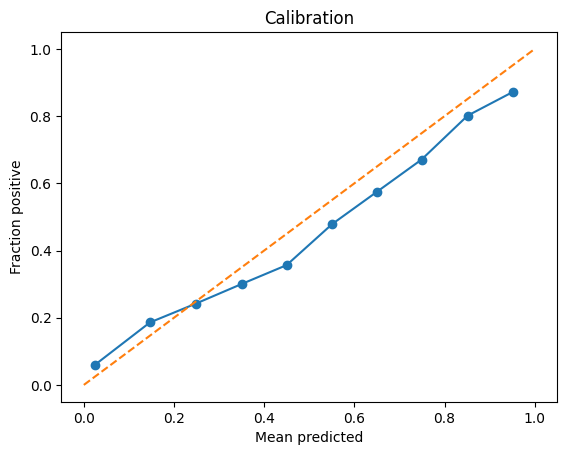

In [ ]:
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

prec, rec, thr = precision_recall_curve(y_test, proba)
plt.figure(); plt.plot(rec,prec); plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy="uniform")
plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],'--'); plt.title("Calibration"); plt.xlabel("Mean predicted"); plt.ylabel("Fraction positive"); plt.show()


In [ ]:
test = X_test.copy()
test["opp_size"] = X_test["Opportunity Size (USD)"].values
test["y_true"]   = y_test.values
test["pwin_ml"]  = proba
test["exp_rev_ml"] = test["pwin_ml"] * test["opp_size"]
test["actual_rev"] = np.where(test["y_true"]==1, test["opp_size"], 0.0)

In [ ]:
group_cols = ["Technology Primary","B2B Sales Medium"]
hist_rates = (data.groupby(group_cols)["is_won"].mean()
              .rename("hist_win_rate").reset_index())

test = test.merge(hist_rates, on=group_cols, how="left")
overall = data["is_won"].mean()
test["hist_win_rate"] = test["hist_win_rate"].fillna(overall)
test["exp_rev_base"]  = test["hist_win_rate"] * test["opp_size"]

In [ ]:
rmse = lambda a,b: np.sqrt(np.mean((a-b)**2))
mae  = lambda a,b: np.mean(np.abs(a-b))

print("\nExpected Revenue error (per opportunity):")
print(" ML   – RMSE:", round(rmse(test["actual_rev"], test["exp_rev_ml"]), 2),
      " MAE:", round(mae(test["actual_rev"], test["exp_rev_ml"]), 2))
print(" Base – RMSE:", round(rmse(test["actual_rev"], test["exp_rev_base"]), 2),
      " MAE:", round(mae(test["actual_rev"], test["exp_rev_base"]), 2))


Expected Revenue error (per opportunity):
 ML   – RMSE: 11846.84  MAE: 5746.22
 Base – RMSE: 13563.67  MAE: 9117.48


In [ ]:
print("\nPortfolio totals (test set):")
print("Actual total revenue   :", round(test["actual_rev"].sum(), 2))
print("ML expected total      :", round(test["exp_rev_ml"].sum(), 2))
print("Baseline expected total:", round(test["exp_rev_base"].sum(), 2))


Portfolio totals (test set):
Actual total revenue   : 73924102.0
ML expected total      : 71098718.6
Baseline expected total: 84622987.58


In [ ]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, precision_recall_curve, roc_auc_score,
                             average_precision_score)
from sklearn.calibration import calibration_curve

In [ ]:
needed = [
    "Opportunity ID","Technology Primary","City","B2B Sales Medium",
    "Sales Velocity","Opportunity Status","Sales Stage Iterations",
    "Opportunity Size (USD)","Client Revenue Sizing","Client Employee Sizing",
    "Business from Client Last Year","Compete Intel"
]
df = df[[c for c in needed if c in df.columns]].copy()


In [ ]:
def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, name), dpi=200)
    plt.close()

In [ ]:
needed = [
    "Opportunity ID","Technology Primary","City","B2B Sales Medium",
    "Sales Velocity","Opportunity Status","Sales Stage Iterations",
    "Opportunity Size (USD)","Client Revenue Sizing","Client Employee Sizing",
    "Business from Client Last Year","Compete Intel"
]
df = df[[c for c in needed if c in df.columns]].copy()

df = df.dropna(subset=["Opportunity Status","Opportunity Size (USD)"])
df["is_won"] = (df["Opportunity Status"].str.strip().str.lower()=="won").astype(int)
df["actual_revenue"] = np.where(df["is_won"].eq(1), df["Opportunity Size (USD)"], 0.0)

def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, name), dpi=200)
    plt.close()


Text(0, 0.5, 'Count')

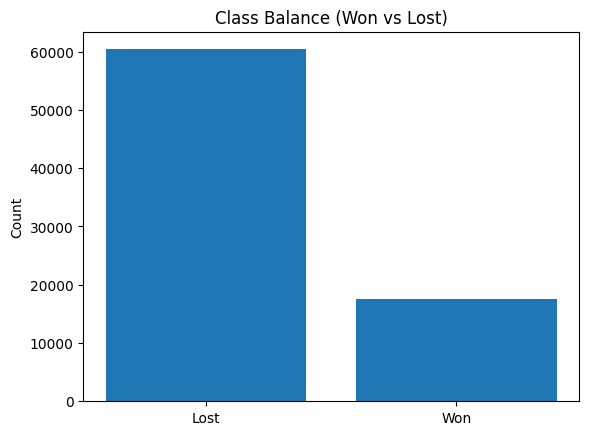

In [ ]:
counts = df["is_won"].value_counts().rename(index={0:"Lost",1:"Won"})
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Balance (Won vs Lost)")
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

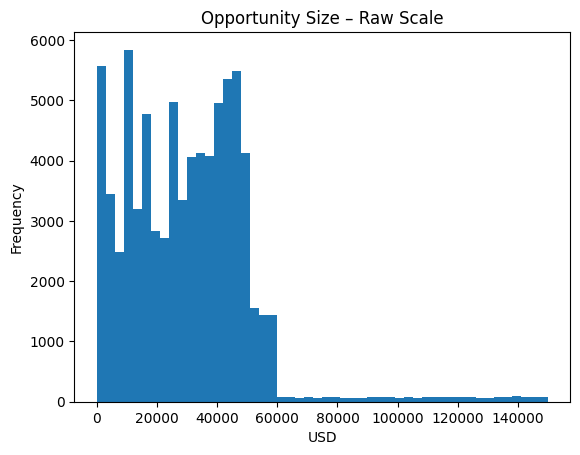

In [ ]:
plt.figure()
plt.hist(df["Opportunity Size (USD)"], bins=50)
plt.title("Opportunity Size – Raw Scale")
plt.xlabel("USD"); plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

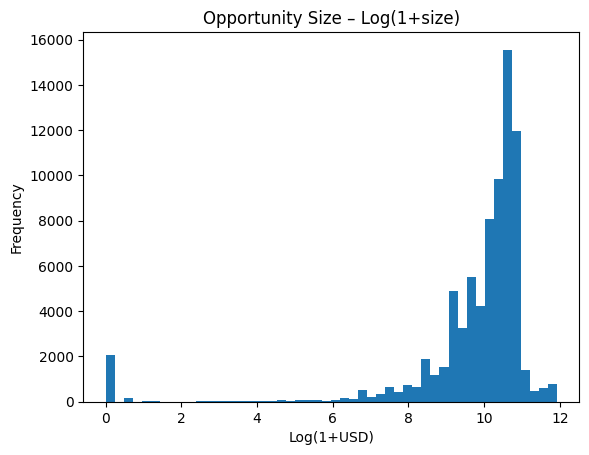

In [ ]:
plt.figure()
plt.hist(np.log1p(df["Opportunity Size (USD)"]), bins=50)
plt.title("Opportunity Size – Log(1+size)")
plt.xlabel("Log(1+USD)"); plt.ylabel("Frequency")

/tmp/ipython-input-2940912471.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)
/tmp/ipython-input-2940912471.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)
/tmp/ipython-input-2940912471.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


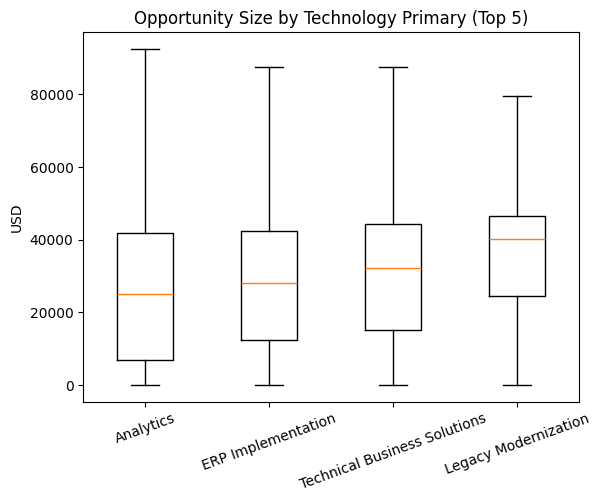

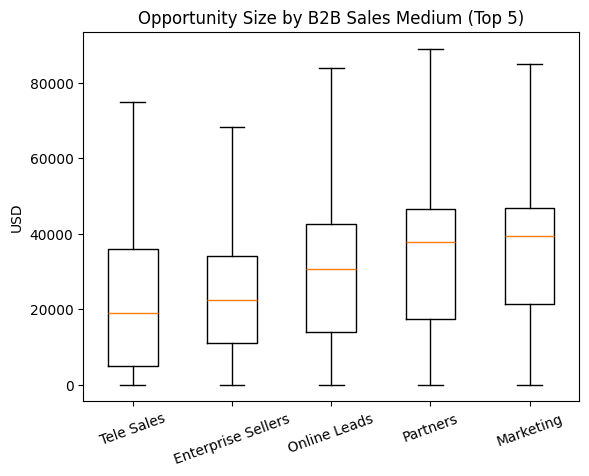

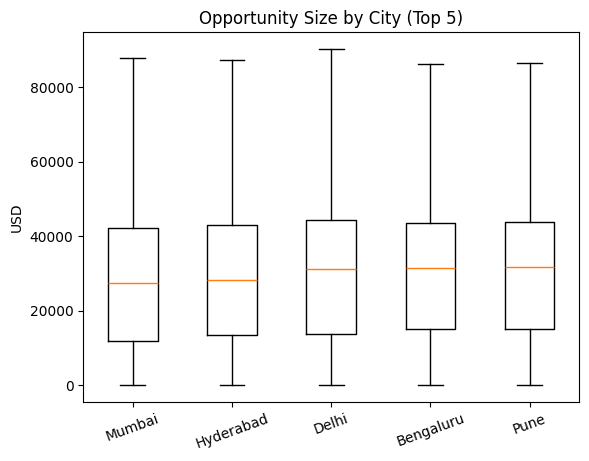

In [ ]:
def top_k(series, k=5):
    return series.value_counts().nlargest(k).index.tolist()

for col in ["Technology Primary","B2B Sales Medium","City"]:
    if col not in df.columns:
        continue
    cats = top_k(df[col].dropna(), 5)
    sub  = df[df[col].isin(cats)].copy()
    order= sorted(cats, key=lambda c: sub.loc[sub[col]==c, "Opportunity Size (USD)"].median())
    plt.figure()
    data = [sub.loc[sub[col]==c, "Opportunity Size (USD)"] for c in order]
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title(f"Opportunity Size by {col} (Top 5)")
    plt.ylabel("USD")
    plt.xticks(rotation=20)

NameError: name 'PLOT_DIR' is not defined

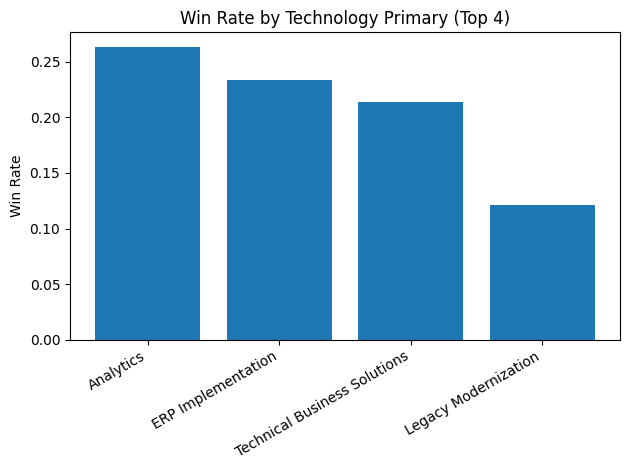

In [ ]:
def win_rate_bar(col, topn=10):
    if col not in df.columns: return
    wr = df.groupby(col)["is_won"].mean().sort_values(ascending=False)
    wr = wr.head(topn)
    plt.figure()
    plt.bar(wr.index.astype(str), wr.values)
    plt.title(f"Win Rate by {col} (Top {len(wr)})")
    plt.ylabel("Win Rate")
    plt.xticks(rotation=30, ha="right")
    savefig(f"06_winrate_by_{col.replace(' ','_')}.png")

for c in ["Technology Primary","B2B Sales Medium","City","Compete Intel"]:
    win_rate_bar(c, topn=10 if c!="City" else 8)

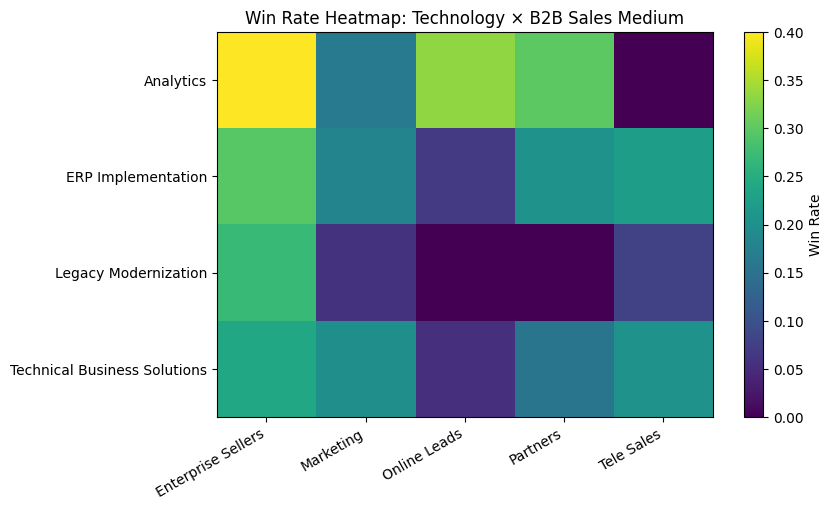

In [ ]:
if set(["Technology Primary","B2B Sales Medium"]).issubset(df.columns):
    pv = df.pivot_table(index="Technology Primary", columns="B2B Sales Medium",
                        values="is_won", aggfunc="mean")
    plt.figure(figsize=(8,5))
    im = plt.imshow(pv.values, aspect="auto")
    plt.colorbar(im, label="Win Rate")
    plt.xticks(range(len(pv.columns)), pv.columns, rotation=30, ha="right")
    plt.yticks(range(len(pv.index)), pv.index)
    plt.title("Win Rate Heatmap: Technology × B2B Sales Medium")

In [ ]:
feature_cols = [c for c in df.columns if c not in
                ["Opportunity ID","Opportunity Status","is_won","actual_revenue"]]
X = df[feature_cols].copy()
y = df["is_won"].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

rf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
)
pipe = Pipeline([("prep", pre), ("rf", rf)])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe.fit(Xtr, ytr)
p = pipe.predict_proba(Xte)[:,1]


KeyboardInterrupt: 

NameError: name 'PLOT_DIR' is not defined

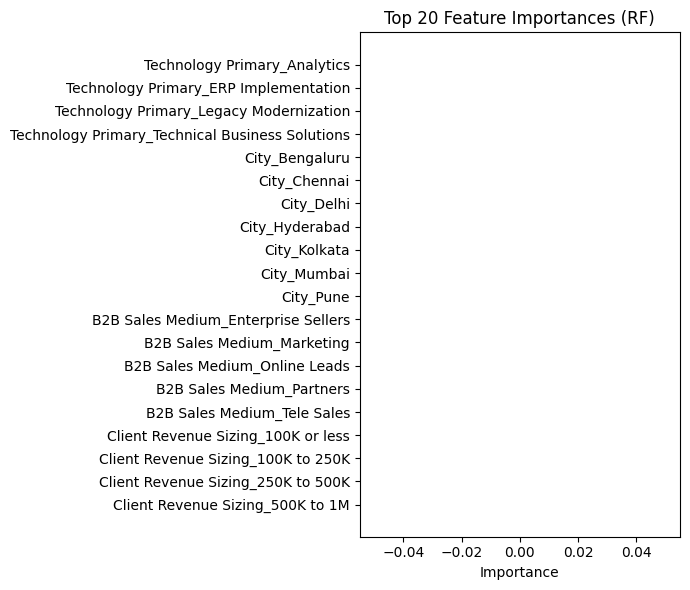

In [ ]:
rf_model = pipe.named_steps["rf"]
oh = pipe.named_steps["prep"].named_transformers_["cat"]
cat_names = oh.get_feature_names_out(cat_cols).tolist() if len(cat_cols)>0 else []
feature_names = cat_names + num_cols
imp = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(7,6))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.title("Top 20 Feature Importances (RF)")
plt.xlabel("Importance")
savefig("11_feature_importance_top20.png")

In [ ]:
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, name), dpi=200)
    plt.close()

Text(0.5, 0, 'Importance')

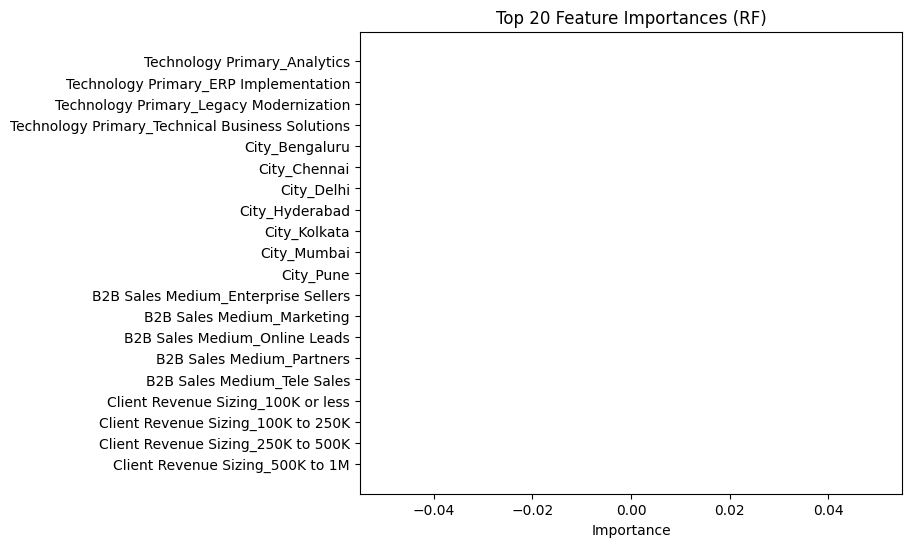

In [ ]:
rf_model = pipe.named_steps["rf"]
oh = pipe.named_steps["prep"].named_transformers_["cat"]
cat_names = oh.get_feature_names_out(cat_cols).tolist() if len(cat_cols)>0 else []
feature_names = cat_names + num_cols
imp = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(7,6))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.title("Top 20 Feature Importances (RF)")
plt.xlabel("Importance")

In [ ]:
print(f"All plots saved in folder: {PLOT_DIR}")

All plots saved in folder: plots
